In [2]:
import os
from pathlib import Path

import numpy as np
import pandas as pd

from predictability.utils import ProteinGym, StructuralCharacterizer, update_environment_variables, download_pdb
from predictability.plotting import show_structure, get_ngl_colorings, plot_marginal_probabilities
from predictability.constants import DATA_ROOT, PROJECT_ROOT

In [3]:
update_environment_variables("zsh")

In [4]:
GLOBAL_DATA_ROOT = os.getenv("DATA_ROOT")

# Filtering ProteinGym for enzymatic assays

In [5]:
gym = ProteinGym(
    proteingym_location=Path(GLOBAL_DATA_ROOT) / "public/proteingym",
    meta_data_path=Path(GLOBAL_DATA_ROOT) / "public/proteingym/substitutions_raw_DMS/DMS_substitutions.csv"
)
gym.update_reference_information()

2024-03-12 14:40:02.262 | INFO     | predictability.utils:update_reference_information:357 - Updating reference information with structure information.


In [5]:
reference_info = gym.reference_information
selection = reference_info[
    (reference_info["seq_len"] <= 600) &
    (reference_info["DMS_number_single_mutants"] > 1000) &
    (reference_info["active_site"] != "") &
    (reference_info["structure_covers_mutated_region"] == True) &
    (reference_info["coarse_selection_type"].map(lambda x: x in ("OrganismalFitness", "Activity")))
]
selection

,DMS_id,DMS_filename,UniProt_ID,taxon,source_organism,target_seq,seq_len,includes_multiple_mutants,DMS_total_number_mutants,DMS_number_single_mutants,...,raw_DMS_mutant_column,weight_file_name,pdb_file,ProteinGym_version,raw_mut_offset,coarse_selection_type,has_pdb_structure,structure_covers_mutated_region,uniprot_sequence,active_site
14,AMIE_PSEAE_Wrenbeck_2017,AMIE_PSEAE_Wrenbeck_2017.csv,AMIE_PSEAE,Prokaryote,Pseudomonas aeruginosa,MRHGDISSSNDTVGVAVVNYKMPRLHTAAEVLDNARKIAEMIVGMK...,346,False,6227,6227,...,mutant,AMIE_PSEAE_theta_0.2.npy,AMIE_PSEAE.pdb,0.1,NaN,Activity,True,True,MRHGDISSSNDTVGVAVVNYKMPRLHTAAEVLDNARKIAEMIVGMK...,59-134-166
20,BLAT_ECOLX_Deng_2012,BLAT_ECOLX_Deng_2012.csv,BLAT_ECOLX,Prokaryote,Escherichia coli,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,286,False,4996,4996,...,mutant,BLAT_ECOLX_theta_0.2.npy,BLAT_ECOLX.pdb,0.1,NaN,OrganismalFitness,True,True,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,68-166
21,BLAT_ECOLX_Firnberg_2014,BLAT_ECOLX_Firnberg_2014.csv,BLAT_ECOLX,Prokaryote,Escherichia coli,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,286,False,4783,4783,...,mutant,BLAT_ECOLX_theta_0.2.npy,BLAT_ECOLX.pdb,0.1,NaN,OrganismalFitness,True,True,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,68-166
23,BLAT_ECOLX_Stiffler_2015,BLAT_ECOLX_Stiffler_2015.csv,BLAT_ECOLX,Prokaryote,Escherichia coli,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,286,False,4996,4996,...,mutant,BLAT_ECOLX_theta_0.2.npy,BLAT_ECOLX.pdb,0.1,NaN,OrganismalFitness,True,True,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,68-166
32,CASP3_HUMAN_Roychowdhury_2020,CASP3_HUMAN_Roychowdhury_2020.csv,CASP3_HUMAN,Human,Homo sapiens,MSGISLDNSYKMDYPEMGLCIIINNKNFHKSTGMTSRSGTDVDAAN...,258,False,1567,1567,...,mutant,CASP3_HUMAN_theta0.2_2023-08-07_b01.npy,CASP3_HUMAN.pdb,1.0,NaN,Activity,True,True,MENTENSVDSKSIKNLEPKIIHGSESMDSGISLDNSYKMDYPEMGL...,121-163
95,MK01_HUMAN_Brenan_2016,MK01_HUMAN_Brenan_2016.csv,MK01_HUMAN,Human,Homo sapiens,MAAAAAAGAGPEMVRGQVFDVGPRYTNLSYIGEGAYGMVCSAYDNV...,360,False,6809,6809,...,mutant,MK01_HUMAN_theta_0.2.npy,MK01_HUMAN.pdb,0.1,NaN,OrganismalFitness,True,True,MAAAAAAGAGPEMVRGQVFDVGPRYTNLSYIGEGAYGMVCSAYDNV...,149
138,PTEN_HUMAN_Mighell_2018,PTEN_HUMAN_Mighell_2018.csv,PTEN_HUMAN,Human,Homo sapiens,MTAIIKEIVSRNKRRYQEDGFDLDLTYIYPNIIAMGFPAERLEGVY...,403,False,7260,7260,...,mutant,PTEN_HUMAN_theta_0.2.npy,PTEN_HUMAN.pdb,0.1,NaN,Activity,True,True,MTAIIKEIVSRNKRRYQEDGFDLDLTYIYPNIIAMGFPAERLEGVY...,124
190,SRC_HUMAN_Ahler_2019,SRC_HUMAN_Ahler_2019.csv,SRC_HUMAN,Human,Homo sapiens,MGSNKSKPKDASQRRRSLEPAENVHGAGGGAFPASQTPSKPASADG...,536,False,3372,3372,...,mutant_uniprot_1,SRC_HUMAN_theta_0.2.npy,SRC_HUMAN.pdb,0.1,NaN,Activity,True,True,MGSNKSKPKDASQRRRSLEPAENVHGAGGGAFPASQTPSKPASADG...,389
191,SRC_HUMAN_Chakraborty_2023_binding-DAS_25uM,SRC_HUMAN_Chakraborty_2023_binding-DAS_25uM.csv,SRC_HUMAN,Human,S. Cerevisiae,MGSNKSKPKDASQRRRSLEPAENVHGAGGGAFPASQTPSKPASADG...,536,False,3637,3637,...,mutant,SRC_HUMAN_theta0.2_2023-08-07_b06.npy,SRC_HUMAN.pdb,1.0,NaN,Activity,True,True,MGSNKSKPKDASQRRRSLEPAENVHGAGGGAFPASQTPSKPASADG...,389
192,SRC_HUMAN_Nguyen_2022,SRC_HUMAN_Nguyen_2022.csv,SRC_HUMAN,Human,Human,MGSNKSKPKDASQRRRSLEPAENVHGAGGGAFPASQTPSKPASADG...,536,False,3366,3366,...,mutant,SRC_HUMAN_theta0.2_2023-08-07_b06.npy,SRC_HUMAN.pdb,1.0,NaN,OrganismalFitness,True,True,MGSNKSKPKDASQRRRSLEPAENVHGAGGGAFPASQTPSKPASADG...,389


In [6]:
non_activity_dms_ids = ["SRC_HUMAN_Chakraborty_2023_binding-DAS_25uM", "SRC_HUMAN_Nguyen_2022"]

In [7]:
final_selection = selection[selection["DMS_id"].map(lambda x: x not in non_activity_dms_ids)]
final_selection

,DMS_id,DMS_filename,UniProt_ID,taxon,source_organism,target_seq,seq_len,includes_multiple_mutants,DMS_total_number_mutants,DMS_number_single_mutants,...,raw_DMS_mutant_column,weight_file_name,pdb_file,ProteinGym_version,raw_mut_offset,coarse_selection_type,has_pdb_structure,structure_covers_mutated_region,uniprot_sequence,active_site
14,AMIE_PSEAE_Wrenbeck_2017,AMIE_PSEAE_Wrenbeck_2017.csv,AMIE_PSEAE,Prokaryote,Pseudomonas aeruginosa,MRHGDISSSNDTVGVAVVNYKMPRLHTAAEVLDNARKIAEMIVGMK...,346,False,6227,6227,...,mutant,AMIE_PSEAE_theta_0.2.npy,AMIE_PSEAE.pdb,0.1,NaN,Activity,True,True,MRHGDISSSNDTVGVAVVNYKMPRLHTAAEVLDNARKIAEMIVGMK...,59-134-166
20,BLAT_ECOLX_Deng_2012,BLAT_ECOLX_Deng_2012.csv,BLAT_ECOLX,Prokaryote,Escherichia coli,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,286,False,4996,4996,...,mutant,BLAT_ECOLX_theta_0.2.npy,BLAT_ECOLX.pdb,0.1,NaN,OrganismalFitness,True,True,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,68-166
21,BLAT_ECOLX_Firnberg_2014,BLAT_ECOLX_Firnberg_2014.csv,BLAT_ECOLX,Prokaryote,Escherichia coli,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,286,False,4783,4783,...,mutant,BLAT_ECOLX_theta_0.2.npy,BLAT_ECOLX.pdb,0.1,NaN,OrganismalFitness,True,True,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,68-166
23,BLAT_ECOLX_Stiffler_2015,BLAT_ECOLX_Stiffler_2015.csv,BLAT_ECOLX,Prokaryote,Escherichia coli,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,286,False,4996,4996,...,mutant,BLAT_ECOLX_theta_0.2.npy,BLAT_ECOLX.pdb,0.1,NaN,OrganismalFitness,True,True,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,68-166
32,CASP3_HUMAN_Roychowdhury_2020,CASP3_HUMAN_Roychowdhury_2020.csv,CASP3_HUMAN,Human,Homo sapiens,MSGISLDNSYKMDYPEMGLCIIINNKNFHKSTGMTSRSGTDVDAAN...,258,False,1567,1567,...,mutant,CASP3_HUMAN_theta0.2_2023-08-07_b01.npy,CASP3_HUMAN.pdb,1.0,NaN,Activity,True,True,MENTENSVDSKSIKNLEPKIIHGSESMDSGISLDNSYKMDYPEMGL...,121-163
95,MK01_HUMAN_Brenan_2016,MK01_HUMAN_Brenan_2016.csv,MK01_HUMAN,Human,Homo sapiens,MAAAAAAGAGPEMVRGQVFDVGPRYTNLSYIGEGAYGMVCSAYDNV...,360,False,6809,6809,...,mutant,MK01_HUMAN_theta_0.2.npy,MK01_HUMAN.pdb,0.1,NaN,OrganismalFitness,True,True,MAAAAAAGAGPEMVRGQVFDVGPRYTNLSYIGEGAYGMVCSAYDNV...,149
138,PTEN_HUMAN_Mighell_2018,PTEN_HUMAN_Mighell_2018.csv,PTEN_HUMAN,Human,Homo sapiens,MTAIIKEIVSRNKRRYQEDGFDLDLTYIYPNIIAMGFPAERLEGVY...,403,False,7260,7260,...,mutant,PTEN_HUMAN_theta_0.2.npy,PTEN_HUMAN.pdb,0.1,NaN,Activity,True,True,MTAIIKEIVSRNKRRYQEDGFDLDLTYIYPNIIAMGFPAERLEGVY...,124
190,SRC_HUMAN_Ahler_2019,SRC_HUMAN_Ahler_2019.csv,SRC_HUMAN,Human,Homo sapiens,MGSNKSKPKDASQRRRSLEPAENVHGAGGGAFPASQTPSKPASADG...,536,False,3372,3372,...,mutant_uniprot_1,SRC_HUMAN_theta_0.2.npy,SRC_HUMAN.pdb,0.1,NaN,Activity,True,True,MGSNKSKPKDASQRRRSLEPAENVHGAGGGAFPASQTPSKPASADG...,389
205,UBC9_HUMAN_Weile_2017,UBC9_HUMAN_Weile_2017.csv,UBC9_HUMAN,Human,Homo sapiens,MSGIALSRLAQERKAWRKDHPFGFVAVPTKNPDGTMNLMNWECAIP...,159,False,2563,2563,...,mutant,UBC9_HUMAN_theta_0.2.npy,UBC9_HUMAN.pdb,0.1,NaN,OrganismalFitness,True,True,MSGIALSRLAQERKAWRKDHPFGFVAVPTKNPDGTMNLMNWECAIP...,93


# Assigning structural characteristics and exporting as .csv files 

In [6]:
color_map = {
    0: "white",
    1: "firebrick"
}

# AMIE_PSEAE_Wrenbeck_2017

In [9]:
dms_id = "AMIE_PSEAE_Wrenbeck_2017"
uniprot_id = gym.reference_information.loc[gym.reference_information["DMS_id"] == dms_id, "UniProt_ID"].values[0]
active_site = gym.reference_information.loc[
    gym.reference_information["DMS_id"] == dms_id, "active_site"
].map(lambda x: [int(pos) for pos in x.split("-")]).values[0]
data_dir = DATA_ROOT / f"{dms_id}"
data_dir.mkdir(parents=True, exist_ok=True)
data = gym.prepare_dataset(dms_id)
data.to_csv(data_dir / "data.csv")
gym.available_pdbs[uniprot_id]

['DR   PDB; 2UXY; X-ray; 1.25 A; A=1-341.']

In [10]:
pdb_id = "2UXY"
pdb_file_path = data_dir / f"{pdb_id}.pdb"
download_pdb(pdb_id, data_dir)
sc = StructuralCharacterizer(str(pdb_file_path), active_site_residues=active_site)
sc.residue_characteristics.to_csv(data_dir / "structural_characteristics.csv")
colorings = get_ngl_colorings(sc.residue_characteristics, color_map)

@> 2971 atoms and 1 coordinate set(s) were parsed in 0.02s.


In [48]:
view = show_structure(pdb_file_path, colorings["is_buried"])
view

NGLWidget()

In [49]:
view = show_structure(pdb_file_path, colorings["is_connected"])
view

NGLWidget()

In [50]:
view = show_structure(pdb_file_path, colorings["is_close_to_as"])
view

NGLWidget()

In [51]:
view = show_structure(pdb_file_path, colorings["is_secondary"])
view

NGLWidget()

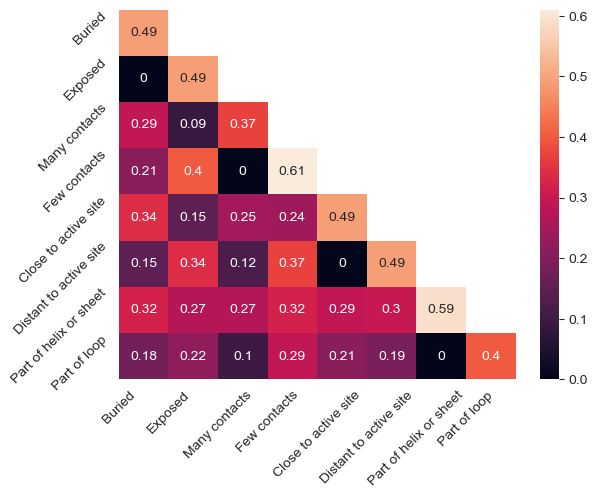

In [18]:
# Marginal probabilities
from predictability.plotting import features_to_df_descriptors
sequence_length = gym.reference_information[gym.reference_information["DMS_id"] == dms_id]["seq_len"].values[0]
p_matrix = np.empty((8, 8))
for i, class_name_1 in enumerate(features_to_df_descriptors.keys()):
    for j, class_name_2 in enumerate(features_to_df_descriptors.keys()):
        residues_1 = sc.residue_characteristics[
            sc.residue_characteristics[features_to_df_descriptors[class_name_1][0]] == features_to_df_descriptors[class_name_1][1]
        ]["residue_number"]
        residues_2 = sc.residue_characteristics[
            sc.residue_characteristics[features_to_df_descriptors[class_name_2][0]] == features_to_df_descriptors[class_name_2][1]
        ]["residue_number"]
        intersection = set(residues_1).intersection(residues_2)
        p_matrix[i, j] = len(intersection) / sequence_length
fig, ax = plot_marginal_probabilities(p_matrix, features_to_df_descriptors.keys())
fig.savefig(PROJECT_ROOT / f"results/{dms_id}/marginal_probabilities.pdf")

# BLAT_ECOLX_Deng_2012

In [19]:
dms_id = "BLAT_ECOLX_Deng_2012"
uniprot_id = gym.reference_information.loc[gym.reference_information["DMS_id"] == dms_id, "UniProt_ID"].values[0]
active_site = gym.reference_information.loc[
    gym.reference_information["DMS_id"] == dms_id, "active_site"
].map(lambda x: [int(pos) for pos in x.split("-")]).values[0]
data_dir = DATA_ROOT / f"{dms_id}"
data_dir.mkdir(parents=True, exist_ok=True)
data = gym.prepare_dataset(dms_id)
data.to_csv(data_dir / "data.csv")
gym.available_pdbs[uniprot_id]

['DR   PDB; 1AXB; X-ray; 2.00 A; A=24-286.',
 'DR   PDB; 1BT5; X-ray; 1.80 A; A=24-286.',
 'DR   PDB; 1BTL; X-ray; 1.80 A; A=24-286.',
 'DR   PDB; 1CK3; X-ray; 2.28 A; A=24-284.',
 'DR   PDB; 1ERM; X-ray; 1.70 A; A=24-286.',
 'DR   PDB; 1ERO; X-ray; 2.10 A; A=24-286.',
 'DR   PDB; 1ERQ; X-ray; 1.90 A; A=24-286.',
 'DR   PDB; 1ESU; X-ray; 2.00 A; A=24-284.',
 'DR   PDB; 1FQG; X-ray; 1.70 A; A=24-286.',
 'DR   PDB; 1JTD; X-ray; 2.30 A; A=24-286.',
 'DR   PDB; 1JTG; X-ray; 1.73 A; A/C=24-286.',
 'DR   PDB; 1JVJ; X-ray; 1.73 A; A=24-286.',
 'DR   PDB; 1JWP; X-ray; 1.75 A; A=24-286.',
 'DR   PDB; 1JWV; X-ray; 1.85 A; A=24-286.',
 'DR   PDB; 1JWZ; X-ray; 1.80 A; A=24-286.',
 'DR   PDB; 1LHY; X-ray; 2.00 A; A=24-284.',
 'DR   PDB; 1LI0; X-ray; 1.61 A; A=24-284.',
 'DR   PDB; 1LI9; X-ray; 1.52 A; A=24-284.',
 'DR   PDB; 1M40; X-ray; 0.85 A; A=24-286.',
 'DR   PDB; 1NXY; X-ray; 1.60 A; A=24-286.',
 'DR   PDB; 1NY0; X-ray; 1.75 A; A=24-286.',
 'DR   PDB; 1NYM; X-ray; 1.20 A; A=24-286.',
 'DR   P

In [20]:
pdb_id = "1ZG4"
pdb_file_path = data_dir / f"{pdb_id}.pdb"
download_pdb(pdb_id, data_dir)
sc = StructuralCharacterizer(str(pdb_file_path), active_site_residues=active_site)
sc.residue_characteristics.to_csv(data_dir / "structural_characteristics.csv")
colorings = get_ngl_colorings(sc.residue_characteristics, color_map)

@> 2224 atoms and 1 coordinate set(s) were parsed in 0.01s.


In [55]:
view = show_structure(pdb_file_path, colorings["is_buried"])
view

NGLWidget()

In [56]:
view = show_structure(pdb_file_path, colorings["is_connected"])
view

NGLWidget()

In [57]:
view = show_structure(pdb_file_path, colorings["is_close_to_as"])
view

NGLWidget()

In [58]:
view = show_structure(pdb_file_path, colorings["is_secondary"])
view

NGLWidget()

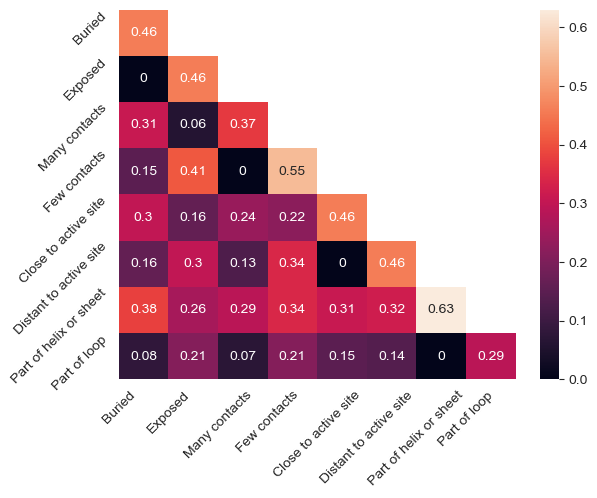

In [21]:
# Marginal probabilities
from predictability.plotting import features_to_df_descriptors
sequence_length = gym.reference_information[gym.reference_information["DMS_id"] == dms_id]["seq_len"].values[0]
p_matrix = np.empty((8, 8))
for i, class_name_1 in enumerate(features_to_df_descriptors.keys()):
    for j, class_name_2 in enumerate(features_to_df_descriptors.keys()):
        residues_1 = sc.residue_characteristics[
            sc.residue_characteristics[features_to_df_descriptors[class_name_1][0]] == features_to_df_descriptors[class_name_1][1]
        ]["residue_number"]
        residues_2 = sc.residue_characteristics[
            sc.residue_characteristics[features_to_df_descriptors[class_name_2][0]] == features_to_df_descriptors[class_name_2][1]
        ]["residue_number"]
        intersection = set(residues_1).intersection(residues_2)
        p_matrix[i, j] = len(intersection) / sequence_length
fig, ax = plot_marginal_probabilities(p_matrix, features_to_df_descriptors.keys())
fig.savefig(PROJECT_ROOT / f"results/{dms_id}/marginal_probabilities.pdf")

# BLAT_ECOLX_Firnberg_2014

In [22]:
dms_id = "BLAT_ECOLX_Firnberg_2014"
uniprot_id = gym.reference_information.loc[gym.reference_information["DMS_id"] == dms_id, "UniProt_ID"].values[0]
active_site = gym.reference_information.loc[
    gym.reference_information["DMS_id"] == dms_id, "active_site"
].map(lambda x: [int(pos) for pos in x.split("-")]).values[0]
data_dir = DATA_ROOT / f"{dms_id}"
data_dir.mkdir(parents=True, exist_ok=True)
data = gym.prepare_dataset(dms_id)
data.to_csv(data_dir / "data.csv")

In [23]:
pdb_id = "1ZG4"
pdb_file_path = data_dir / f"{pdb_id}.pdb"
download_pdb(pdb_id, data_dir)
sc = StructuralCharacterizer(str(pdb_file_path), active_site_residues=active_site)
sc.residue_characteristics.to_csv(data_dir / "structural_characteristics.csv")

@> 2224 atoms and 1 coordinate set(s) were parsed in 0.01s.


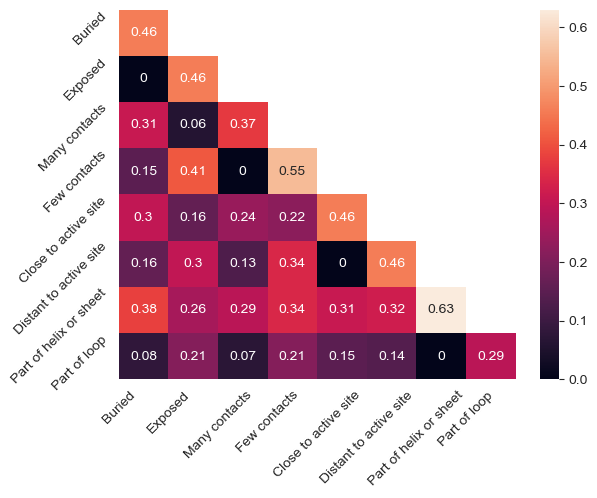

In [24]:
# Marginal probabilities
from predictability.plotting import features_to_df_descriptors
sequence_length = gym.reference_information[gym.reference_information["DMS_id"] == dms_id]["seq_len"].values[0]
p_matrix = np.empty((8, 8))
for i, class_name_1 in enumerate(features_to_df_descriptors.keys()):
    for j, class_name_2 in enumerate(features_to_df_descriptors.keys()):
        residues_1 = sc.residue_characteristics[
            sc.residue_characteristics[features_to_df_descriptors[class_name_1][0]] == features_to_df_descriptors[class_name_1][1]
        ]["residue_number"]
        residues_2 = sc.residue_characteristics[
            sc.residue_characteristics[features_to_df_descriptors[class_name_2][0]] == features_to_df_descriptors[class_name_2][1]
        ]["residue_number"]
        intersection = set(residues_1).intersection(residues_2)
        p_matrix[i, j] = len(intersection) / sequence_length
fig, ax = plot_marginal_probabilities(p_matrix, features_to_df_descriptors.keys())
fig.savefig(PROJECT_ROOT / f"results/{dms_id}/marginal_probabilities.pdf")

# BLAT_ECOLX_Stiffler_2015

In [25]:
dms_id = "BLAT_ECOLX_Stiffler_2015"
uniprot_id = gym.reference_information.loc[gym.reference_information["DMS_id"] == dms_id, "UniProt_ID"].values[0]
active_site = gym.reference_information.loc[
    gym.reference_information["DMS_id"] == dms_id, "active_site"
].map(lambda x: [int(pos) for pos in x.split("-")]).values[0]
data_dir = DATA_ROOT / f"{dms_id}"
data_dir.mkdir(parents=True, exist_ok=True)
data = gym.prepare_dataset(dms_id)
data.to_csv(data_dir / "data.csv")

In [26]:
pdb_id = "1ZG4"
pdb_file_path = data_dir / f"{pdb_id}.pdb"
download_pdb(pdb_id, data_dir)
sc = StructuralCharacterizer(str(pdb_file_path), active_site_residues=active_site)
sc.residue_characteristics.to_csv(data_dir / "structural_characteristics.csv")

@> 2224 atoms and 1 coordinate set(s) were parsed in 0.01s.


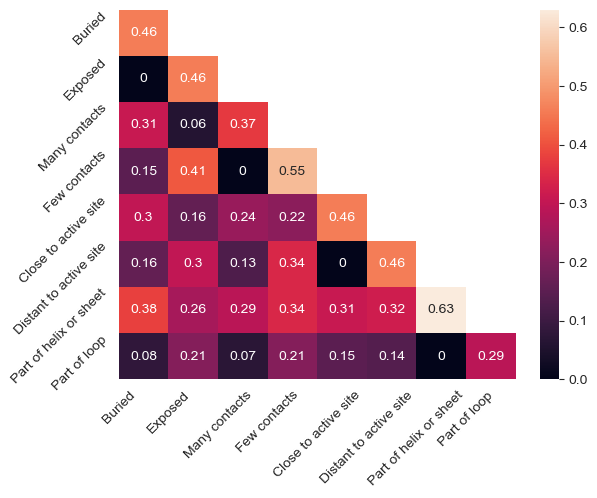

In [27]:
# Marginal probabilities
from predictability.plotting import features_to_df_descriptors
sequence_length = gym.reference_information[gym.reference_information["DMS_id"] == dms_id]["seq_len"].values[0]
p_matrix = np.empty((8, 8))
for i, class_name_1 in enumerate(features_to_df_descriptors.keys()):
    for j, class_name_2 in enumerate(features_to_df_descriptors.keys()):
        residues_1 = sc.residue_characteristics[
            sc.residue_characteristics[features_to_df_descriptors[class_name_1][0]] == features_to_df_descriptors[class_name_1][1]
        ]["residue_number"]
        residues_2 = sc.residue_characteristics[
            sc.residue_characteristics[features_to_df_descriptors[class_name_2][0]] == features_to_df_descriptors[class_name_2][1]
        ]["residue_number"]
        intersection = set(residues_1).intersection(residues_2)
        p_matrix[i, j] = len(intersection) / sequence_length
fig, ax = plot_marginal_probabilities(p_matrix, features_to_df_descriptors.keys())
fig.savefig(PROJECT_ROOT / f"results/{dms_id}/marginal_probabilities.pdf")

# CASP3_HUMAN_Roychowdhury_2020

In [28]:
dms_id = "CASP3_HUMAN_Roychowdhury_2020"
uniprot_id = gym.reference_information.loc[gym.reference_information["DMS_id"] == dms_id, "UniProt_ID"].values[0]
active_site = gym.reference_information.loc[
    gym.reference_information["DMS_id"] == dms_id, "active_site"
].map(lambda x: [int(pos) for pos in x.split("-")]).values[0]
data_dir = DATA_ROOT / f"{dms_id}"
data_dir.mkdir(parents=True, exist_ok=True)
data = gym.prepare_dataset(dms_id)
data.to_csv(data_dir / "data.csv")
gym.available_pdbs[uniprot_id]

['DR   PDB; 1CP3; X-ray; 2.30 A; A/B=1-277.',
 'DR   PDB; 1GFW; X-ray; 2.80 A; A=29-175, B=181-277.',
 'DR   PDB; 1I3O; X-ray; 2.70 A; A/C=1-175, B/D=176-277.',
 'DR   PDB; 1NME; X-ray; 1.60 A; A=29-174, B=186-277.',
 'DR   PDB; 1NMQ; X-ray; 2.40 A; A/B=29-277.',
 'DR   PDB; 1NMS; X-ray; 1.70 A; A/B=29-277.',
 'DR   PDB; 1PAU; X-ray; 2.50 A; A=29-175, B=176-277.',
 'DR   PDB; 1QX3; X-ray; 1.90 A; A=29-277.',
 'DR   PDB; 1RE1; X-ray; 2.50 A; A=29-175, B=176-277.',
 'DR   PDB; 1RHJ; X-ray; 2.20 A; A/C=29-175, B/D=176-277.',
 'DR   PDB; 1RHK; X-ray; 2.50 A; A=29-175, B=176-277.',
 'DR   PDB; 1RHM; X-ray; 2.50 A; A/C=29-175, B/D=176-277.',
 'DR   PDB; 1RHQ; X-ray; 3.00 A; A/D=29-175, B/E=176-277.',
 'DR   PDB; 1RHR; X-ray; 3.00 A; A=29-175, B=176-277.',
 'DR   PDB; 1RHU; X-ray; 2.51 A; A=29-175, B=176-277.',
 'DR   PDB; 2C1E; X-ray; 1.77 A; A=29-175, B=176-277.',
 'DR   PDB; 2C2K; X-ray; 1.87 A; A=29-175, B=176-277.',
 'DR   PDB; 2C2M; X-ray; 1.94 A; A=29-175, B=176-277.',
 'DR   PDB; 2C2O

In [29]:
pdb_id = "4EHD"
pdb_file_path = data_dir / f"{pdb_id}.pdb"
download_pdb(pdb_id, data_dir)
sc = StructuralCharacterizer(str(pdb_file_path), active_site_residues=active_site)
sc.residue_characteristics.to_csv(data_dir / "structural_characteristics.csv")
colorings = get_ngl_colorings(sc.residue_characteristics, color_map)

@> 2209 atoms and 1 coordinate set(s) were parsed in 0.01s.


In [67]:
view = show_structure(pdb_file_path, colorings["is_buried"])
view

NGLWidget()

In [68]:
view = show_structure(pdb_file_path, colorings["is_connected"])
view

NGLWidget()

In [69]:
view = show_structure(pdb_file_path, colorings["is_close_to_as"])
view

NGLWidget()

In [70]:
view = show_structure(pdb_file_path, colorings["is_secondary"])
view

NGLWidget()

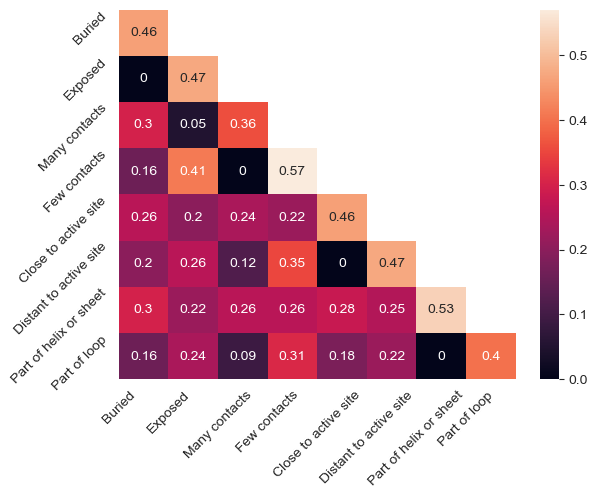

In [30]:
# Marginal probabilities
from predictability.plotting import features_to_df_descriptors
sequence_length = gym.reference_information[gym.reference_information["DMS_id"] == dms_id]["seq_len"].values[0]
p_matrix = np.empty((8, 8))
for i, class_name_1 in enumerate(features_to_df_descriptors.keys()):
    for j, class_name_2 in enumerate(features_to_df_descriptors.keys()):
        residues_1 = sc.residue_characteristics[
            sc.residue_characteristics[features_to_df_descriptors[class_name_1][0]] == features_to_df_descriptors[class_name_1][1]
        ]["residue_number"]
        residues_2 = sc.residue_characteristics[
            sc.residue_characteristics[features_to_df_descriptors[class_name_2][0]] == features_to_df_descriptors[class_name_2][1]
        ]["residue_number"]
        intersection = set(residues_1).intersection(residues_2)
        p_matrix[i, j] = len(intersection) / sequence_length
fig, ax = plot_marginal_probabilities(p_matrix, features_to_df_descriptors.keys())
fig.savefig(PROJECT_ROOT / f"results/{dms_id}/marginal_probabilities.pdf")

# MK01_HUMAN_Brenan_2016

In [31]:
dms_id = "MK01_HUMAN_Brenan_2016"
uniprot_id = gym.reference_information.loc[gym.reference_information["DMS_id"] == dms_id, "UniProt_ID"].values[0]
active_site = gym.reference_information.loc[
    gym.reference_information["DMS_id"] == dms_id, "active_site"
].map(lambda x: [int(pos) for pos in x.split("-")]).values[0]
data_dir = DATA_ROOT / f"{dms_id}"
data_dir.mkdir(parents=True, exist_ok=True)
data = gym.prepare_dataset(dms_id)
data.to_csv(data_dir / "data.csv")
gym.available_pdbs[uniprot_id]

['DR   PDB; 1PME; X-ray; 2.00 A; A=1-360.',
 'DR   PDB; 1TVO; X-ray; 2.50 A; A=1-360.',
 'DR   PDB; 1WZY; X-ray; 2.50 A; A=1-360.',
 'DR   PDB; 2OJG; X-ray; 2.00 A; A=2-360.',
 'DR   PDB; 2OJI; X-ray; 2.60 A; A=2-360.',
 'DR   PDB; 2OJJ; X-ray; 2.40 A; A=2-360.',
 'DR   PDB; 2Y9Q; X-ray; 1.55 A; A=1-360.',
 'DR   PDB; 3D42; X-ray; 2.46 A; B=184-191.',
 'DR   PDB; 3D44; X-ray; 1.90 A; B=184-191.',
 'DR   PDB; 3I5Z; X-ray; 2.20 A; A=1-360.',
 'DR   PDB; 3I60; X-ray; 2.50 A; A=1-360.',
 'DR   PDB; 3SA0; X-ray; 1.59 A; A=1-360.',
 'DR   PDB; 3TEI; X-ray; 2.40 A; A=1-360.',
 'DR   PDB; 3W55; X-ray; 3.00 A; A=1-360.',
 'DR   PDB; 4FMQ; X-ray; 2.10 A; A=1-360.',
 'DR   PDB; 4FUX; X-ray; 2.20 A; A=1-360.',
 'DR   PDB; 4FUY; X-ray; 2.00 A; A=1-360.',
 'DR   PDB; 4FV0; X-ray; 2.10 A; A=1-360.',
 'DR   PDB; 4FV1; X-ray; 1.99 A; A=1-360.',
 'DR   PDB; 4FV2; X-ray; 2.00 A; A=1-360.',
 'DR   PDB; 4FV3; X-ray; 2.20 A; A=1-360.',
 'DR   PDB; 4FV4; X-ray; 2.50 A; A=1-360.',
 'DR   PDB; 4FV5; X-ray; 2.4

In [32]:
pdb_id = "1PME"
pdb_file_path = data_dir / f"{pdb_id}.pdb"
download_pdb(pdb_id, data_dir)
sc = StructuralCharacterizer(str(pdb_file_path), active_site_residues=active_site)
sc.residue_characteristics.to_csv(data_dir / "structural_characteristics.csv")
colorings = get_ngl_colorings(sc.residue_characteristics, color_map)

@> 2973 atoms and 1 coordinate set(s) were parsed in 0.02s.


In [73]:
view = show_structure(pdb_file_path, colorings["is_buried"])
view

NGLWidget()

In [74]:
view = show_structure(pdb_file_path, colorings["is_connected"])
view

NGLWidget()

In [75]:
view = show_structure(pdb_file_path, colorings["is_close_to_as"])
view

NGLWidget()

In [77]:
view = show_structure(pdb_file_path, colorings["is_secondary"])
view

NGLWidget()

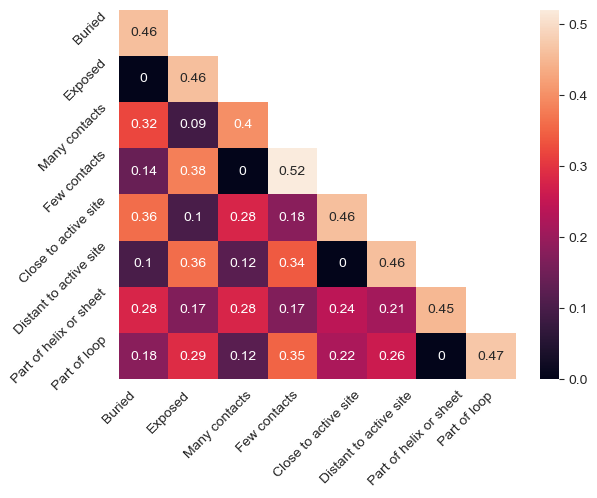

In [33]:
# Marginal probabilities
from predictability.plotting import features_to_df_descriptors
sequence_length = gym.reference_information[gym.reference_information["DMS_id"] == dms_id]["seq_len"].values[0]
p_matrix = np.empty((8, 8))
for i, class_name_1 in enumerate(features_to_df_descriptors.keys()):
    for j, class_name_2 in enumerate(features_to_df_descriptors.keys()):
        residues_1 = sc.residue_characteristics[
            sc.residue_characteristics[features_to_df_descriptors[class_name_1][0]] == features_to_df_descriptors[class_name_1][1]
        ]["residue_number"]
        residues_2 = sc.residue_characteristics[
            sc.residue_characteristics[features_to_df_descriptors[class_name_2][0]] == features_to_df_descriptors[class_name_2][1]
        ]["residue_number"]
        intersection = set(residues_1).intersection(residues_2)
        p_matrix[i, j] = len(intersection) / sequence_length
fig, ax = plot_marginal_probabilities(p_matrix, features_to_df_descriptors.keys())
fig.savefig(PROJECT_ROOT / f"results/{dms_id}/marginal_probabilities.pdf")

# PTEN_HUMAN_Mighell_2018

In [34]:
dms_id = "PTEN_HUMAN_Mighell_2018"
uniprot_id = gym.reference_information.loc[gym.reference_information["DMS_id"] == dms_id, "UniProt_ID"].values[0]
active_site = gym.reference_information.loc[
    gym.reference_information["DMS_id"] == dms_id, "active_site"
].map(lambda x: [int(pos) for pos in x.split("-")]).values[0]
data_dir = DATA_ROOT / f"{dms_id}"
data_dir.mkdir(parents=True, exist_ok=True)
data = gym.prepare_dataset(dms_id)
data.to_csv(data_dir / "data.csv")
gym.available_pdbs[uniprot_id]

['DR   PDB; 1D5R; X-ray; 2.10 A; A=8-353.',
 'DR   PDB; 2KYL; NMR; -; B=391-403.',
 'DR   PDB; 4O1V; X-ray; 2.00 A; B=354-368.',
 'DR   PDB; 5BUG; X-ray; 2.40 A; A/B/C/D=14-351.',
 'DR   PDB; 5BZX; X-ray; 2.50 A; A/B/C/D=14-351.',
 'DR   PDB; 5BZZ; X-ray; 2.20 A; A/B/C/D=14-351.',
 'DR   PDB; 7JTX; X-ray; 3.23 A; A=7-395.',
 'DR   PDB; 7JUK; X-ray; 3.15 A; A=7-353, A=378-390.',
 'DR   PDB; 7JUL; X-ray; 2.53 A; A=7-353, A=378-390.',
 'DR   PDB; 7JVX; X-ray; 3.20 A; A=1-403.',
 'DR   PDB; 7PC7; X-ray; 2.10 A; E/F=394-403.']

In [35]:
pdb_id = "7JVX"
pdb_file_path = data_dir / f"{pdb_id}.pdb"
download_pdb(pdb_id, data_dir)
sc = StructuralCharacterizer(str(pdb_file_path), active_site_residues=active_site)
sc.residue_characteristics.to_csv(data_dir / "structural_characteristics.csv")
colorings = get_ngl_colorings(sc.residue_characteristics, color_map)

@> 2639 atoms and 1 coordinate set(s) were parsed in 0.01s.


In [36]:
data["residue_number"] = data["mutant"].map(lambda x: int(x[1:-1]))
mean_per_position = data.groupby("residue_number").agg({"DMS_score": "mean"}).rename(
    columns={"DMS_score": "mean_effect"})
std_per_position = data.groupby("residue_number").agg({"DMS_score": "std"}).rename(
    columns={"DMS_score": "std_effect"})
effect_statistics = mean_per_position.merge(std_per_position, on="residue_number").reset_index()
effect_statistics.to_csv(data_dir / "per_residue_effect_statistics.csv", index=None)

In [81]:
view = show_structure(pdb_file_path, colorings["is_buried"])
view

NGLWidget()

In [82]:
view = show_structure(pdb_file_path, colorings["is_connected"])
view

NGLWidget()

In [83]:
view = show_structure(pdb_file_path, colorings["is_close_to_as"])
view

NGLWidget()

In [84]:
view = show_structure(pdb_file_path, colorings["is_secondary"])
view

NGLWidget()

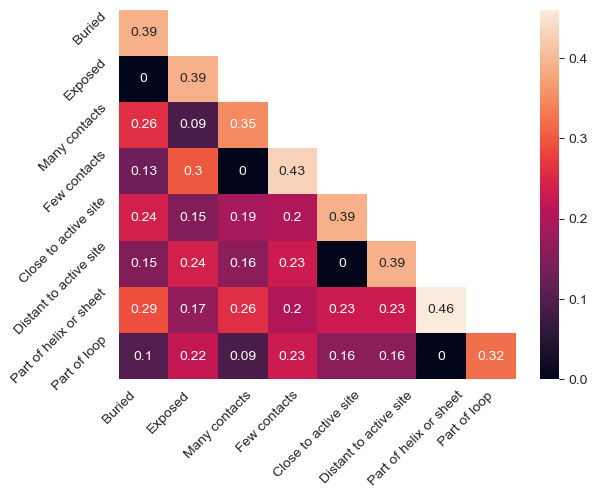

In [38]:
# Marginal probabilities
from predictability.plotting import features_to_df_descriptors
sequence_length = gym.reference_information[gym.reference_information["DMS_id"] == dms_id]["seq_len"].values[0]
p_matrix = np.empty((8, 8))
for i, class_name_1 in enumerate(features_to_df_descriptors.keys()):
    for j, class_name_2 in enumerate(features_to_df_descriptors.keys()):
        residues_1 = sc.residue_characteristics[
            sc.residue_characteristics[features_to_df_descriptors[class_name_1][0]] == features_to_df_descriptors[class_name_1][1]
        ]["residue_number"]
        residues_2 = sc.residue_characteristics[
            sc.residue_characteristics[features_to_df_descriptors[class_name_2][0]] == features_to_df_descriptors[class_name_2][1]
        ]["residue_number"]
        intersection = set(residues_1).intersection(residues_2)
        p_matrix[i, j] = len(intersection) / sequence_length
fig, ax = plot_marginal_probabilities(p_matrix, features_to_df_descriptors.keys())
fig.savefig(PROJECT_ROOT / f"results/{dms_id}/marginal_probabilities.pdf")

# SRC_HUMAN_Ahler_2019

In [39]:
dms_id = "SRC_HUMAN_Ahler_2019"
uniprot_id = gym.reference_information.loc[gym.reference_information["DMS_id"] == dms_id, "UniProt_ID"].values[0]
active_site = gym.reference_information.loc[
    gym.reference_information["DMS_id"] == dms_id, "active_site"
].map(lambda x: [int(pos) for pos in x.split("-")]).values[0]
data_dir = DATA_ROOT / f"{dms_id}"
data_dir.mkdir(parents=True, exist_ok=True)
data = gym.prepare_dataset(dms_id)
data.to_csv(data_dir / "data.csv")
gym.available_pdbs[uniprot_id]

['DR   PDB; 1A07; X-ray; 2.20 A; A/B=144-249.',
 'DR   PDB; 1A08; X-ray; 2.20 A; A/B=144-249.',
 'DR   PDB; 1A09; X-ray; 2.00 A; A/B=144-249.',
 'DR   PDB; 1A1A; X-ray; 2.00 A; A/B=144-249.',
 'DR   PDB; 1A1B; X-ray; 2.20 A; A/B=144-249.',
 'DR   PDB; 1A1C; X-ray; 2.40 A; A/B=144-249.',
 'DR   PDB; 1A1E; X-ray; 2.20 A; A/B=144-249.',
 'DR   PDB; 1FMK; X-ray; 1.50 A; A=86-536.',
 'DR   PDB; 1HCS; NMR; -; B=144-249.',
 'DR   PDB; 1HCT; NMR; -; B=144-249.',
 'DR   PDB; 1KSW; X-ray; 2.80 A; A=86-536.',
 'DR   PDB; 1O41; X-ray; 1.70 A; A=145-252.',
 'DR   PDB; 1O42; X-ray; 1.70 A; A=145-252.',
 'DR   PDB; 1O43; X-ray; 1.50 A; A=145-252.',
 'DR   PDB; 1O44; X-ray; 1.70 A; A=145-252.',
 'DR   PDB; 1O45; X-ray; 1.80 A; A=145-252.',
 'DR   PDB; 1O46; X-ray; 2.00 A; A=145-252.',
 'DR   PDB; 1O47; X-ray; 1.80 A; A=145-252.',
 'DR   PDB; 1O48; X-ray; 1.55 A; A=145-252.',
 'DR   PDB; 1O49; X-ray; 1.70 A; A=145-252.',
 'DR   PDB; 1O4A; X-ray; 1.50 A; A=145-252.',
 'DR   PDB; 1O4B; X-ray; 1.85 A; A=1

In [40]:
pdb_id = "2H8H"
pdb_file_path = data_dir / f"{pdb_id}.pdb"
download_pdb(pdb_id, data_dir)
sc = StructuralCharacterizer(str(pdb_file_path), active_site_residues=active_site)
sc.residue_characteristics.to_csv(data_dir / "structural_characteristics.csv")
colorings = get_ngl_colorings(sc.residue_characteristics, color_map)

@> 3840 atoms and 1 coordinate set(s) were parsed in 0.02s.


In [87]:
view = show_structure(pdb_file_path, colorings["is_buried"])
view

NGLWidget()

In [88]:
view = show_structure(pdb_file_path, colorings["is_connected"])
view

NGLWidget()

In [89]:
view = show_structure(pdb_file_path, colorings["is_close_to_as"])
view

NGLWidget()

In [90]:
view = show_structure(pdb_file_path, colorings["is_secondary"])
view

NGLWidget()

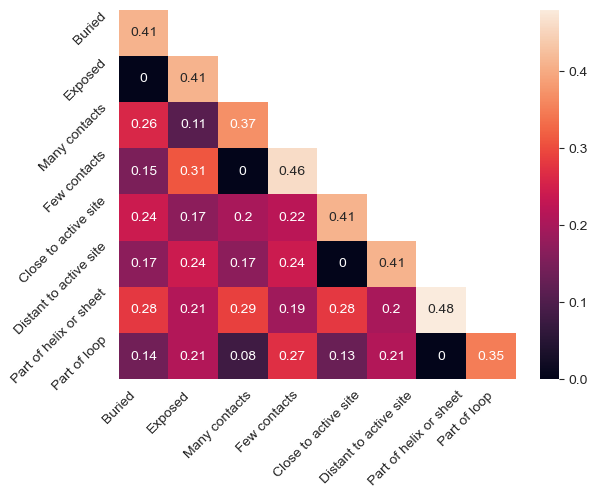

In [41]:
# Marginal probabilities
from predictability.plotting import features_to_df_descriptors
sequence_length = gym.reference_information[gym.reference_information["DMS_id"] == dms_id]["seq_len"].values[0]
p_matrix = np.empty((8, 8))
for i, class_name_1 in enumerate(features_to_df_descriptors.keys()):
    for j, class_name_2 in enumerate(features_to_df_descriptors.keys()):
        residues_1 = sc.residue_characteristics[
            sc.residue_characteristics[features_to_df_descriptors[class_name_1][0]] == features_to_df_descriptors[class_name_1][1]
        ]["residue_number"]
        residues_2 = sc.residue_characteristics[
            sc.residue_characteristics[features_to_df_descriptors[class_name_2][0]] == features_to_df_descriptors[class_name_2][1]
        ]["residue_number"]
        intersection = set(residues_1).intersection(residues_2)
        p_matrix[i, j] = len(intersection) / sequence_length
fig, ax = plot_marginal_probabilities(p_matrix, features_to_df_descriptors.keys())
fig.savefig(PROJECT_ROOT / f"results/{dms_id}/marginal_probabilities.pdf")

# UBC9_HUMAN_Weile_2017

In [42]:
dms_id = "UBC9_HUMAN_Weile_2017"
uniprot_id = gym.reference_information.loc[gym.reference_information["DMS_id"] == dms_id, "UniProt_ID"].values[0]
active_site = gym.reference_information.loc[
    gym.reference_information["DMS_id"] == dms_id, "active_site"
].map(lambda x: [int(pos) for pos in x.split("-")]).values[0]
data_dir = DATA_ROOT / f"{dms_id}"
data_dir.mkdir(parents=True, exist_ok=True)
data = gym.prepare_dataset(dms_id)
data.to_csv(data_dir / "data.csv")
gym.available_pdbs[uniprot_id]

['DR   PDB; 1A3S; X-ray; 2.80 A; A=1-158.',
 'DR   PDB; 1KPS; X-ray; 2.50 A; A/C=1-158.',
 'DR   PDB; 1Z5S; X-ray; 3.01 A; A=1-158.',
 'DR   PDB; 2GRN; X-ray; 1.80 A; A=1-158.',
 'DR   PDB; 2GRO; X-ray; 1.70 A; A=1-158.',
 'DR   PDB; 2GRP; X-ray; 2.05 A; A=1-158.',
 'DR   PDB; 2GRQ; X-ray; 1.70 A; A=1-158.',
 'DR   PDB; 2GRR; X-ray; 1.30 A; A=1-158.',
 'DR   PDB; 2O25; X-ray; 2.60 A; C/D=1-158.',
 'DR   PDB; 2PE6; X-ray; 2.40 A; A=1-158.',
 'DR   PDB; 2PX9; NMR; -; B=1-158.',
 'DR   PDB; 2XWU; X-ray; 2.80 A; A=1-158.',
 'DR   PDB; 3A4S; X-ray; 2.70 A; A/B=1-158.',
 'DR   PDB; 3UIN; X-ray; 2.60 A; A=1-158.',
 'DR   PDB; 3UIO; X-ray; 2.60 A; A=1-158.',
 'DR   PDB; 3UIP; X-ray; 2.29 A; A=1-158.',
 'DR   PDB; 4W5V; X-ray; 2.50 A; A=1-158.',
 'DR   PDB; 4Y1L; X-ray; 2.70 A; A/B=1-158.',
 'DR   PDB; 5D2M; X-ray; 2.40 A; A/D=1-158.',
 'DR   PDB; 5F6D; X-ray; 1.55 A; A=2-158.',
 'DR   PDB; 5F6E; X-ray; 1.12 A; A=2-158.',
 'DR   PDB; 5F6U; X-ray; 1.55 A; A=2-158.',
 'DR   PDB; 5F6V; X-ray; 1.49

In [43]:
pdb_id = "2GRN"
pdb_file_path = data_dir / f"{pdb_id}.pdb"
download_pdb(pdb_id, data_dir)
sc = StructuralCharacterizer(str(pdb_file_path), active_site_residues=active_site)
sc.residue_characteristics.to_csv(data_dir / "structural_characteristics.csv")
colorings = get_ngl_colorings(sc.residue_characteristics, color_map)

@> 2797 atoms and 1 coordinate set(s) were parsed in 0.01s.


In [102]:
view = show_structure(pdb_file_path, colorings["is_buried"])
view

NGLWidget()

In [103]:
view = show_structure(pdb_file_path, colorings["is_connected"])
view

NGLWidget()

In [104]:
view = show_structure(pdb_file_path, colorings["is_close_to_as"])
view

NGLWidget()

In [105]:
view = show_structure(pdb_file_path, colorings["is_secondary"])
view

NGLWidget()

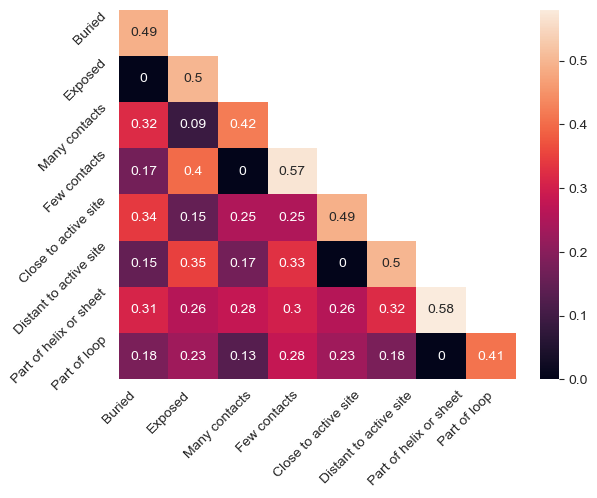

In [44]:
# Marginal probabilities
from predictability.plotting import features_to_df_descriptors
sequence_length = gym.reference_information[gym.reference_information["DMS_id"] == dms_id]["seq_len"].values[0]
p_matrix = np.empty((8, 8))
for i, class_name_1 in enumerate(features_to_df_descriptors.keys()):
    for j, class_name_2 in enumerate(features_to_df_descriptors.keys()):
        residues_1 = sc.residue_characteristics[
            sc.residue_characteristics[features_to_df_descriptors[class_name_1][0]] == features_to_df_descriptors[class_name_1][1]
        ]["residue_number"]
        residues_2 = sc.residue_characteristics[
            sc.residue_characteristics[features_to_df_descriptors[class_name_2][0]] == features_to_df_descriptors[class_name_2][1]
        ]["residue_number"]
        intersection = set(residues_1).intersection(residues_2)
        p_matrix[i, j] = len(intersection) / sequence_length
fig, ax = plot_marginal_probabilities(p_matrix, features_to_df_descriptors.keys())
fig.savefig(PROJECT_ROOT / f"results/{dms_id}/marginal_probabilities.pdf")

# Amylase

In [46]:
dms_id = "amylase"
active_site = [176, 208]
data_dir = DATA_ROOT / f"{dms_id}"
pdb_id = "1UA7"
pdb_file_path = data_dir / f"{pdb_id}.pdb"
download_pdb(pdb_id, data_dir)
sc = StructuralCharacterizer(str(pdb_file_path), active_site_residues=active_site)
sc.residue_characteristics.to_csv(data_dir / "structural_characteristics.csv")
colorings = get_ngl_colorings(sc.residue_characteristics, color_map)

@> 3808 atoms and 1 coordinate set(s) were parsed in 0.02s.


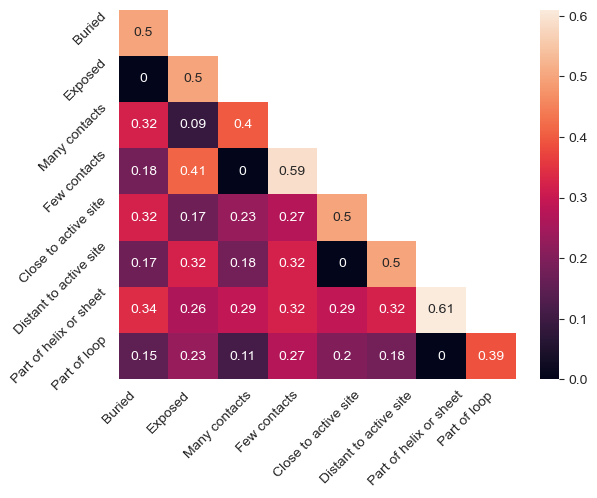

In [48]:
# Marginal probabilities
from predictability.plotting import features_to_df_descriptors
sequence_length = 425
p_matrix = np.empty((8, 8))
for i, class_name_1 in enumerate(features_to_df_descriptors.keys()):
    for j, class_name_2 in enumerate(features_to_df_descriptors.keys()):
        residues_1 = sc.residue_characteristics[
            sc.residue_characteristics[features_to_df_descriptors[class_name_1][0]] == features_to_df_descriptors[class_name_1][1]
        ]["residue_number"]
        residues_2 = sc.residue_characteristics[
            sc.residue_characteristics[features_to_df_descriptors[class_name_2][0]] == features_to_df_descriptors[class_name_2][1]
        ]["residue_number"]
        intersection = set(residues_1).intersection(residues_2)
        p_matrix[i, j] = len(intersection) / sequence_length
fig, ax = plot_marginal_probabilities(p_matrix, features_to_df_descriptors.keys())
fig.savefig(PROJECT_ROOT / f"results/{dms_id}/marginal_probabilities.pdf")

# ASP

In [7]:
dms_id = "asp"
active_site = [32, 56, 137]
data_dir = DATA_ROOT / f"{dms_id}"
pdb_id = "2EA3"
pdb_file_path = data_dir / f"{pdb_id}.pdb"
download_pdb(pdb_id, data_dir)
sc = StructuralCharacterizer(str(pdb_file_path), active_site_residues=active_site)
sc.residue_characteristics.to_csv(data_dir / "structural_characteristics.csv")
colorings = get_ngl_colorings(sc.residue_characteristics, color_map)

@> 1353 atoms and 1 coordinate set(s) were parsed in 0.01s.


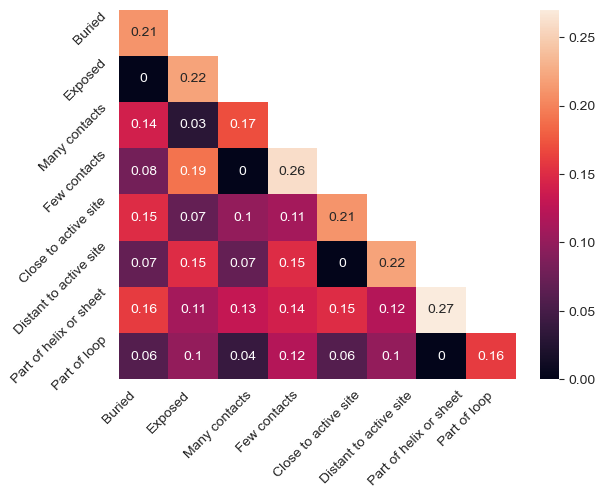

In [8]:
# Marginal probabilities
from predictability.plotting import features_to_df_descriptors
sequence_length = 425
p_matrix = np.empty((8, 8))
for i, class_name_1 in enumerate(features_to_df_descriptors.keys()):
    for j, class_name_2 in enumerate(features_to_df_descriptors.keys()):
        residues_1 = sc.residue_characteristics[
            sc.residue_characteristics[features_to_df_descriptors[class_name_1][0]] == features_to_df_descriptors[class_name_1][1]
        ]["residue_number"]
        residues_2 = sc.residue_characteristics[
            sc.residue_characteristics[features_to_df_descriptors[class_name_2][0]] == features_to_df_descriptors[class_name_2][1]
        ]["residue_number"]
        intersection = set(residues_1).intersection(residues_2)
        p_matrix[i, j] = len(intersection) / sequence_length
fig, ax = plot_marginal_probabilities(p_matrix, features_to_df_descriptors.keys())
fig.savefig(PROJECT_ROOT / f"results/{dms_id}/marginal_probabilities.pdf")